# Visual value iteration and Markov Chain evolution
This notebook provides an example of using the stormvogel API for naive value iteration and Markov Chain evolution, and a way to visualize these algorithms.<br>

## Value iteration
This algorithm takes a model and a target state. It then calculates the probability of reaching the target state from all other states iteratively. If a choice has to be made for an action, the action that gives the best result in the previous iteration is chosen. It also takes an additional parameter epsilon, which indicates the target accuracy. A lower value of epsilon gives a more accurate result with more iterations.

In [1]:
from stormvogel import *

def naive_value_iteration(
    model: Model, epsilon: float, target_state: State
) -> list[list[float]]:
    """Run naive value iteration. The result is a 2D list where result[n][m] is the probability to be in state m at step n.

    Args:
        model (stormvogel.model.Model): Target model.
        steps (int): Amount of steps.
        target_state (stormvogel.model.State): Target state of the model.

    Returns:
        list[list[float]]: The result is a 2D list where result[n][m] is the value of state m at iteration n.
    """
    if epsilon <= 0:
        RuntimeError("The algorithm will not terminate if epsilon is zero.")

    # Create a dynamic matrix (list of lists) to store the result.
    values_matrix = [[0 for state in model.get_states()]]
    values_matrix[0][target_state.id] = 1

    terminate = False
    while not terminate:
        old_values = values_matrix[len(values_matrix) - 1]
        new_values = [None for state in model.get_states()]
        for sid, state in model.get_states().items():
            transitions = model.get_transitions(state)
            # Now we have to take a decision for an action.
            actions = transitions.transition.keys()
            action_values = {}
            for action, branch in transitions.transition.items():
                branch_value = sum([prob * old_values[state.id] for (prob, state) in branch.branch])
                action_values[action] = branch_value
            # We take the action with the highest value.
            highest_value = max(action_values.values())
            new_values[sid] = highest_value
        values_matrix.append(new_values)
        terminate = sum([abs(x-y) for (x, y) in zip(new_values, old_values)]) < epsilon
    return values_matrix
        

To demonstrate the workings of this algorithm, we use the lion model again.

In [2]:
lion = examples.create_lion_mdp()
vis = show(lion, layout=Layout("layouts/lion.json"))

Output()

No free port [(8889, 8905)). See 'Communication server remark' in docs. Disable warning by use_server=False.


Output()

No free port [(8889, 8905)). See 'Communication server remark' in docs. Disable warning by use_server=False.


Now we can display the inner workings of a value iteration algorithm: At the beginning we give the target state a value of 1, then we work backwards, always choosing the action that would maximize the value in the previous iteration. In the end, we always end up converging (This was mathematically proven). The brighter the cell is at the end, the higher the chance that we reach the target state from this state.

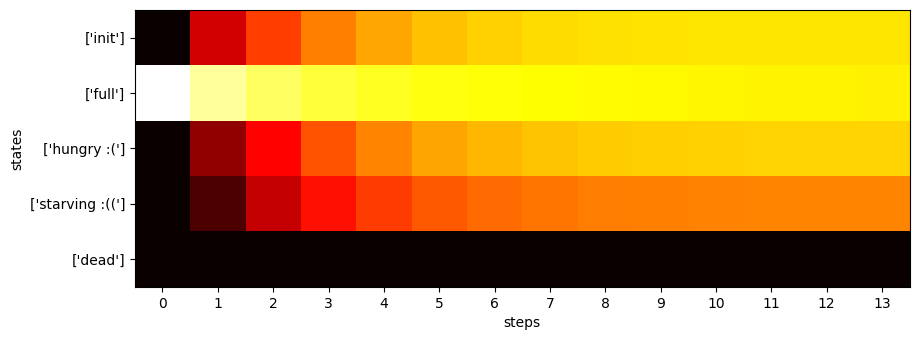

In [3]:
target = lion.get_states_with_label("full")[0]
res = naive_value_iteration(lion, 0.003, target)
labels = lion.get_ordered_labels()
extensions.display_value_iteration_result(res, 10, labels)

Note that naive_value_iteration is also available under `stormvogel.extensions`, in case you would like to use it later. However, this implementation is very inefficient so we recommend using the value iteration algorithms from stormpy if you want good performance.

In [4]:
res2 = extensions.naive_value_iteration(lion, 0.003, lion.get_states_with_label("full")[0])
res == res2

True

## DTMC evolution
An algorithm that is similar to naive value iteration. This time, there is no target state. The algorithm simply applies every probabilistic transition (hence it only works for DTMCs)

This example simulates a die using coin flips.

In [5]:
def dtmc_evolution(model: stormvogel.model.Model, steps: int) -> list[list[float]]:
    """Run DTMC evolution. The result is a 2D list where result[n][m] is the probability to be in state m at step n.

    Args:
        model (stormvogel.model.Model): Target model.
        steps (int): Amount of steps.

    Returns:
        list[list[float]]: The result is a 2D list where result[n][m] is the probability to be in state m at step n.
    """
    if steps < 2:
        RuntimeError("Need at least two steps")
    if model.type != stormvogel.model.ModelType.DTMC:
        RuntimeError("Only works for DTMC")

    # Create a matrix and set the value for the starting state to 1 on the first step.
    matrix_steps_states = [[0.0 for s in model.states] for x in range(steps)]
    matrix_steps_states[0][model.get_initial_state().id] = 1

    # Apply the updated values for each step.
    for current_step in range(steps - 1):
        next_step = current_step + 1
        for s_id, s in model.get_states().items():
            branch = model.get_branch(s)
            for transition_prob, target in branch.branch:
                current_prob = matrix_steps_states[current_step][s_id]
                matrix_steps_states[next_step][target.id] += current_prob * float(
                    transition_prob
                )

    return matrix_steps_states

In [6]:
stormvogel_dtmc = stormpy_to_stormvogel(examples.example_building_dtmcs_01())
vis = show(stormvogel_dtmc)

Output()

No free port [(8889, 8905)). See 'Communication server remark' in docs. Disable warning by use_server=False.


Output()

No free port [(8889, 8905)). See 'Communication server remark' in docs. Disable warning by use_server=False.


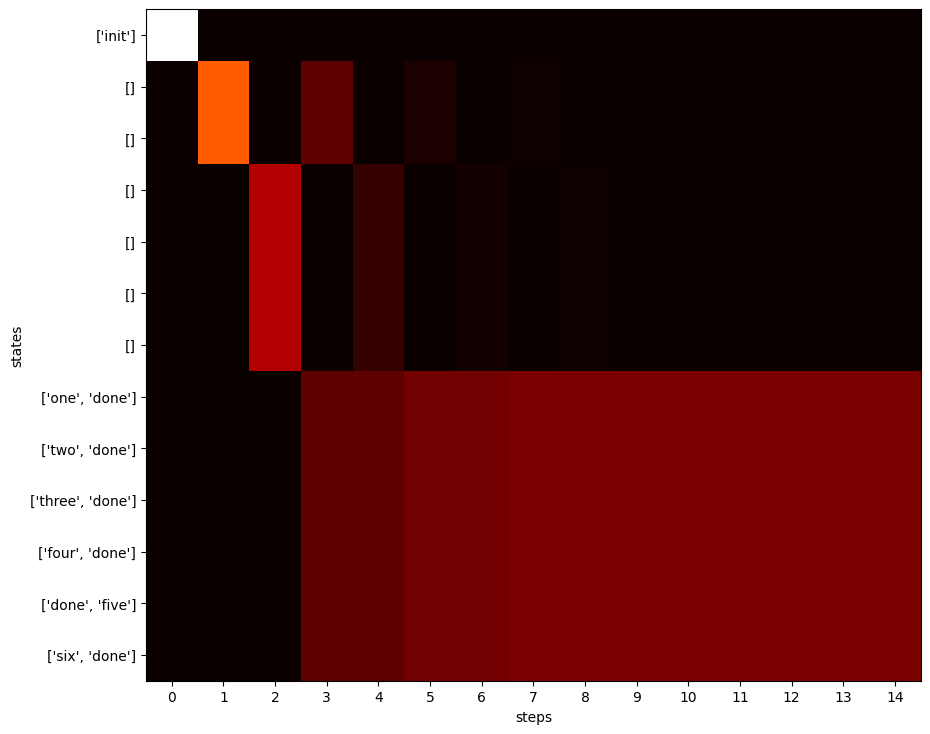

In [7]:
res3 = dtmc_evolution(stormvogel_dtmc, steps=15)
labels = stormvogel_dtmc.get_ordered_labels()
extensions.display_value_iteration_result(res3, 10, labels)

Naive DTMC evolution is also available under stormvogel.extensions.visual_algos.

In [8]:
res4 = extensions.dtmc_evolution(stormvogel_dtmc, 15)
res3 == res4

True